In order to successfully complete this assignment, you must follow all the instructions in this notebook and upload your edited ipynb file to [D2L](http://d2l.msu.edu/) with your answers on or before **10:00am on Friday December 3rd**.

**BIG HINT:** Read the entire homework before starting. 

---
# Homework 5: Applications of Linear Algebra to Data Science

The goal of this final homework assignment is to show you how some of the things you learned in this course can be applied to data science problems and working with real data. We hope you find it interesting!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
sym.init_printing(use_unicode=True)
from sklearn import datasets
import pandas as pd

---
# Outline

1. [Principal Component Analysis](#principal_component_analysis) (70 pts)
2. [Least Squares Fitting with Real Data](#lsf_real_data) (30 pts)

---
<a name="principal_component_analysis"></a>
# 1. Principal Component Analysis (56 pts)

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f5/GaussianScatterPCA.svg" width="40%" alt="Illustration of PCA.">

Image from: [https://en.wikipedia.org/wiki/Principal_component_analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)

In this question we are going to learn about the *Principal Component Analysis (PCA)* algorithm and how to use the Singular Value Decomposition (SVD) to implement PCA. First let us generate some data:

In [2]:
# This cell will generate 2D data - do not change its contents.
mu = np.array([4,2])
cov_mat = np.array([[8, 3], [3, 2]])
X = np.random.multivariate_normal(mu, cov_mat, size=1000)

Our data `X` is stored in a $1000 \times 2$ numpy array. Think of this array as storing $1000$ two-dimensional data points. 

<mark>&#9989; **<font color=red>QUESTION 1.1:</font> (5 pts)** In the cell below, make a scatter plot of the data. To get full credit, make sure to: (1) use `plt.scatter`; (2) make the data points have some transparency using the `alpha` option; (3) turn on the `grid`; and (4) use the option `plt.axis('equal')`. You may also wish to resize the markers used for each point. You should get a plot somewhat like the one above (without the arrows).</mark>

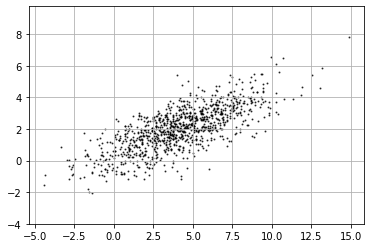

In [3]:
# Make your scatter plot here
plt.grid(True)
plt.axis('equal')
x = X[:,0]
y = X[:,1]
plt.scatter(x,y,s=1,color="Black",alpha=0.7)

The PCA algorithm attempts to find the directions of maximum variance within the data. This can be useful for finding patterns in the data. Looking at the picture above, the longer arrow pointing to the upper right is the direction of maximum variance in that data set, and the shorter arrow pointing to the upper left is the direction with the second most variation in the data that is also orthogonal to the first direction. 

We would like to find these directions in an automated fashion without having to visualize the data and without needing any knowledge of the how the data was generated. Indeed, many data sets of interest are high dimensional and cannot be easily visualized. The principal components can be used as an orthogonal basis for representing the data along coordinates that correspond to decreasing variations within the data. In order to find these coordinates we would like to use tools from linear algebra and think of these principal components as vectors. However, there is a problem, which is that the vectors in the picture above are not "anchored" at the origin; rather they start at the center of the data set itself. However, linear algebra likes its vectors to start at the origin. Therefore, we need to first shift the data to the origin. 

To shift the data to origin, we need to compute the *sample mean* of the data. If we have data $x_1, \ldots, x_N \in \mathbb{R}^d$ (in our case, $N=1000$ and $d=2$), then the mean of the data is:

\begin{equation*}
\bar{x} := \frac{1}{N} \sum_{i=1}^N x_i
\end{equation*}

Note that $\bar{x} \in \mathbb{R}^d$, in other words it is a vector too. Then to *center* the data we subtract $\bar{x}$ from each data point:

\begin{equation*}
z_i = x_i - \bar{x} \, , \quad \text{for all } i = 1, \ldots, N.
\end{equation*}

If you look at the data you plotted, you should see that it is not centered. So let's center it now.

<mark>&#9989; **<font color=red>QUESTION 1.2:</font> (5 pts)** Center your data and store the centered data in the variable `Z`. Using your code from Question 1.1, make a scatter plot of your centered data. You should observe that it is now centered at the origin.</mark>

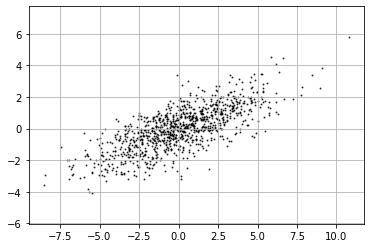

In [5]:
# Put your code here 
Z = np.matrix.copy(X)
mean = sum(X)/1000
for i in range(1000):
    Z[i] = Z[i] - mean
plt.grid(True)
plt.axis('equal')
x = Z[:,0]
y = Z[:,1]
plt.scatter(x,y,s=1,color="Black",alpha=0.7)

With our data centered at the origin, we can now treat each data point as a vector (in this case, each data point is a $2$-vector). We want to find the orthogonal directions of maximum variance within the data. To do so we need to estimate the covariance matrix of the data. 

<mark>&#9989; **<font color=red>QUESTION 1.3:</font> (5 pts)** Compute the $2 \times 2$ *sample covariance matrix* $C = (1/999)Z^T Z$ and store it in the variable `C`. Print `C` and print the variable `cov_mat` defined above, which was the covariance matrix used to generate the data. Spot check visually that `C` is close to `cov_mat`.</mark>

In [6]:
# Put your code here
C = (1/999)*np.dot(Z.T,Z)
print(C)
print(cov_mat)

[[7.97541875 2.91462282]
 [2.91462282 1.93729847]]
[[8 3]
 [3 2]]


It can be seen that `C` and `cov_mat` are close to each other. They have few decimal difference

The matrix $C$ is symmetric, and therefore has two orthonormal eigenvectors. One can also verify the eigenvalues must be non-negative. Let $\lambda_1 \geq \lambda_2$ be the two eigenvalues of $C$, and let $\phi_1$ and $\phi_2$ be the corresponding orthonormal eigenvectors, i.e., $C \phi_i = \lambda_i \phi_i$ for $i=1,2$, $\| \phi_1 \| = \| \phi_2 \| = 1$, and $\phi_1 \cdot \phi_2 = 0$. The first eigenvector, $\phi_1$, points in the direction of the maximum variance within the data set. The second eigenvector, $\phi_2$, points in the orthogonal direction. These eigenvectors are the *principal components* of the data set. The squareroot of the eigenvalues indicates the amount of variance in each direction, i.e., the variance of the data in direction $\phi_1$ is $\sqrt{\lambda_1}$, and the variance of the data in the direction $\phi_2$ is $\sqrt{\lambda_2}$. 

<mark>&#9989; **<font color=red>QUESTION 1.4:</font> (5 pts)** Compute the eigenvectors and eigenvalues of `C` and order the *eigenvalues and corresponding eigenvectors* in order of decreasing eigenvalue so that $\lambda_1 \geq \lambda_2$ and $C \phi_1 = \lambda_1 \phi_1$ and $C \phi_2 = \lambda_2 \phi_2$. Then make a scatter plot of the centered data (same as in Question 1.2), but this time also plot (overlayed in the same figure) $\sqrt{\lambda_1} \phi_1$ and $\sqrt{\lambda_2} \phi_2$ as lines of a different color than the data markers used in your scatter plot (no need to put arrows on these vectors). You should have a plot that is pretty similar to the one at the top of this notebook taken from Wikipedia! Furthermore, you found the directions of maximum variance (i.e., the principal components) in the data in an automated fashion without using any prior knowledge about how the data was generated!</mark> 

In [7]:
# Put your code here
eigvals, eigvecs = np.linalg.eig(C)
print(eigvals)
print(eigvecs)
eigval_1 = eigvals[0]
eigval_2 = eigvals[1]
eigvec_1 = eigvecs[:,0]
eigvec_2 = eigvecs[:,1]

[9.15275591 0.75996131]
[[ 0.92721113 -0.37453907]
 [ 0.37453907  0.92721113]]


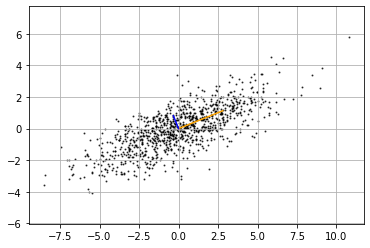

In [8]:
# Put your code here
plt.grid(True)
plt.axis('equal')
x = Z[:,0]
y = Z[:,1]
plt.scatter(x,y,s=1,color="Black",alpha=0.7)
sqrt_1 = np.sqrt(eigval_1) * eigvec_1
sqrt_2 = np.sqrt(eigval_2) * eigvec_2
plt.plot([0,sqrt_1[0]],[0,sqrt_1[1]],color="Orange",alpha=5)
plt.plot([0,sqrt_2[0]],[0,sqrt_2[1]],color="Blue",alpha=5)

<mark>&#9989; **<font color=red>QUESTION 1.5:</font> (5 pts)** For the centered data stored in `Z`, make a change of basis from the standard basis to the orthonormal basis $\mathcal{B} = \{ \phi_1, \phi_2 \}$. You should get a new $1000 \times 2$ matrix/array, which contains the coordinates of your data in the PCA basis $\mathcal{B}$. Store this new coordinate matrix in the variable `Z_pca`. Make a scatter plot of your data in the PCA basis coordinate system.</mark> 

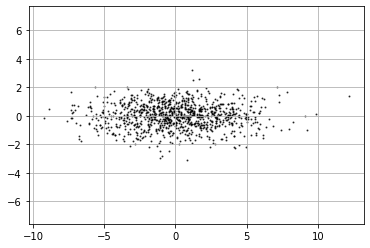

In [9]:
B = eigvecs
Z_pca = np.dot(B.T,Z.T).T
plt.grid(True)
plt.axis('equal')
x = Z_pca[:,0]
y = Z_pca[:,1]
plt.scatter(x,y,s=1,color="Black",alpha=0.7)

<mark>&#9989; **<font color=red>QUESTION 1.6:</font> (5 pts)** Compare your scatter plot of the original data `X` from Question 1.1 and your scatter plot of `Z_pca` from Question 1.5. Describe the transformation from `X` to `Z_pca` using the language of transformation matrices from earlier in the course (i.e., scaling, translation, reflection, rotation, shear). There is no need to write down the matrices precisely, but be clear as to: (1) which transformation matrices get you from `X` to `Z_pca`; (2) what order they need to be applied in; and (3) how you specify the parameters of the matrices you are using (e.g, the scale parameter in a scaling matrix).</mark> 

**The scatter plot 1.5 have been rotated by 45 degrees counterclockwise by using rotation matrix. The plot from 1.1 is not centered so it has been scaled by 3.5 to the left. The manner in which they have applied is first scaling and then rotation.**

When we computed the sample covariance matrix $C = (1/999)Z^T Z$, that may have reminded you of the singular value decomposition (SVD). Let us explore this link further. Recall that the SVD of a matrix $M$ decomposes the matrix as

\begin{equation*}
M = U \Sigma V^T \, .
\end{equation*}

<mark>&#9989; **<font color=red>QUESTION 1.7:</font> (5 pts)** Compute the SVD of `Z` using `numpy` and store the output of the `svd` function in three variables, `U`, `s`, and `Vt`. Verify that the rescaled singular values stored in `s`/$\sqrt{999}$ are equal to the squareroot of the eignvalues you computed in Question 1.4. Additionally, verify that `Vt.T` is equal to the eigenvectors you computed in Question 1.4, up to possible sign changes.</mark>

In [10]:
# Put your code here
U,s,Vt = np.linalg.svd(Z)

In [11]:
triple_nine = np.sqrt(999)
print(s/triple_nine)
print(np.allclose(s[0]/triple_nine,np.sqrt(eigval_1)))
print(np.allclose(s[1]/triple_nine,np.sqrt(eigval_2)))
print(Vt.T)
print(eigvecs)

[3.0253522 0.8717576]
True
True
[[-0.92721113 -0.37453907]
 [-0.37453907  0.92721113]]
[[ 0.92721113 -0.37453907]
 [ 0.37453907  0.92721113]]


As we can see that `Vt.T` is equal to `eigvecs` just such that there is a possible sign change.

<mark>&#9989; **<font color=red>QUESTION 1.8:</font> (5 pts)** Prove that $Z_{\mathrm{pca}} = U \Sigma$, and verify this fact numerically. **Note:** For the numerical part, if in Question 1.7 you needed to flip the sign of one or both of the columns of $V$ to make them align with $\phi_1$ and/or $\phi_2$, then you will need to flip the sign of the corresponding column of $U$ as well.</mark>

 $$Z = U \Sigma V_{t}$$
 $$Z_{\mathrm{pca}} = ZV $$
 $$Z_{\mathrm{pca}} = U \Sigma V_{t} V$$
 $$Z_{\mathrm{pca}} = U \Sigma $$

In [12]:
# Put your code here
E = np.diag(s)
U2 = U[:,0:2]
print(Z_pca)
print(U2@E)
np.allclose(Z_pca,U2@E)

[[ 1.07084471 -0.66734689]
 [-0.57600962 -0.50895283]
 [-2.28803257  0.66878116]
 ...
 [ 3.38017064  1.53975258]
 [-3.25118619  0.92216301]
 [ 1.6793598   0.38654166]]
[[-1.07084471 -0.66734689]
 [ 0.57600962 -0.50895283]
 [ 2.28803257  0.66878116]
 ...
 [-3.38017064  1.53975258]
 [ 3.25118619  0.92216301]
 [-1.6793598   0.38654166]]


False

We can see that `Z_pca` is equal to `U2@E`, but due to some rounding error, `np.allclose(Z_pca,U2@E)` will give false. There are chances it will be true. 

Now let us have some fun. We are going to work with a $4096$ dimensional data set in which each data point is a $64 \times 64$ image of a person's face. The next cell will download this data set for you.

In [13]:
# Download the faces dataset - you should not need to change its contents.
faces = datasets.fetch_olivetti_faces()
print(faces.images.shape)
print(faces.data.shape)

(400, 64, 64)
(400, 4096)


The data is stored in the `faces` variable. `faces.images` stores each face image; from the first `print` statement, we see there are $400$ face images and each one is $64 \times 64$ pixels. `faces.data` stores the same data but the face images have been unwound into a length $64^2 = 4096$ vector. This latter one will be easier to work with, but harder to use for visualization. 

The next cell plots the first $15$ images in the faces data set.

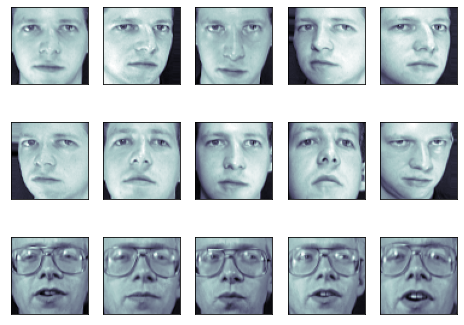

In [14]:
# Plot the first 15 faces
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(faces.images[i], cmap=plt.cm.bone)

Our goal is to run PCA on the faces data set. As we will see below, this will be interesting for a number of reasons. In order to run PCA, we first need to compute the mean of the data set. This mean vector will correspond to the "average face" in the data set. 

<mark>&#9989; **<font color=red>QUESTION 1.9:</font> (5 pts)** Store `faces.data` in the variable `X` (this part is done for you below) and compute the mean of the data set, $\bar{x} \in \mathbb{R}^{4096}$, and store $\bar{x}$ in the variable `x_bar`. Visualize $\bar{x}$ by reshaping `x_bar` into a $64 \times 64$ `numpy array/matrix` and store this reshaped array/matrix in the variable `avg_face`.</mark>

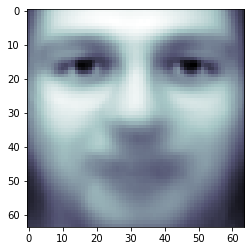

In [15]:
# This line will store faces.data in X
X = faces.data

# DO THIS: Put your code for computing x_bar here
x_bar = sum(X)/400

# DO THIS: Reshape x_bar into a 64x64 numpy matrix/array and store in avg_face
avg_face = x_bar.reshape((64,64))

# This line will display the average face once you have stored it in the variable avg_face
plt.imshow(avg_face, cmap = 'bone')

<mark>&#9989; **<font color=red>QUESTION 1.10:</font> (5 pts)** Mean center the data set `X` and store the mean centered data in the variable `Z`. Compute the SVD of `Z` and store the output in the variables `U`, `s`, and `Vt`. </mark>

In [16]:
# Put your code here
Z = np.zeros((len(X),len(X[0])))
for i in range(400):
    Z[i,:] = X[i,:]-x_bar
U,s,Vt = np.linalg.svd(Z)

Recall from Question 1.7 the rows of `Vt` are the principal components of the data set, which are ordered in terms of decreasing variance. Another way to think about these principal components is that the first one is the single coordinate that explains the most about the data set, the second principal component explains the second most about the data set, and so on. In this case, each principal component is a vector in $\mathbb{R}^{4096}$, but we can reshape those vectors into $64 \times 64$ images. These images are the so-called "eigenfaces." They are face-like images that explain the variations between the different faces in the data set. The next cell will plot the first $15$ eigenfaces, i.e., the first $15$ principal components. 

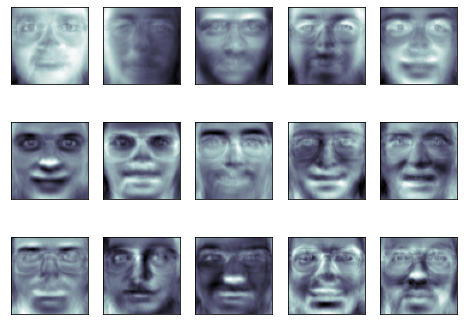

In [17]:
# Display the first 15 eigenfaces (i.e., the first 15 principal components) - no need to edit this cell.
eigenfaces = Vt[:15,:]
eigenfaces = np.reshape(eigenfaces, (15, 64, 64))
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(eigenfaces[i,:,:], cmap=plt.cm.bone)

<mark>&#9989; **<font color=red>QUESTION 1.11:</font> (5 pts)** Take a look at the first $15$ eigenfaces plotted in the previous cell. Describe the different patterns that you see in the eigenfaces. What characteristics of the faces do they correspond to?</mark>

**All the eigenfaces look very different to the original faces. They are centered, many of the glasses like are not seen. The reason for that is that they were compressed, recentered. Becuase of this, they are blurry. The face shape like are more rounded than they were actually. Some of the faces seem to have mustaches even if they do not have it.**

As part of the day 16 in-class work on SVD, you compressed an image by treating that image as a matrix, computed the SVD of that matrix (image), and then only kept some of the singular values. We can do something similar with PCA, except we are are not going to compute the SVD of each image like in the day 16 in-class work, but rather we are going to compute the coordinates of all our face images in the PCA basis. This is more powerful than the day 16 in-class approach because we only need to compute one SVD for all 400 face images (the one we already computed to get the principal components), as opposed to a different SVD for each image.

The first thing we need to do in order to carry out this compression is to decide how many principal components to use. Remember each singular value (rescaled by $1/\sqrt{399}$) measures the variance of the face data along its corresponding principal component (eigenface). The larger the singular value, the more important the principal component. Principal components with small singular values can be discarded and will result in only a small reconstruction error when we try to reconstruct the original faces. The call below plots the singular values rescaled by $1/\sqrt{399}$.

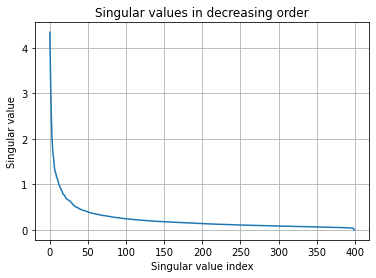

In [18]:
# Plot the singular values - you should not need to change this cell.
plt.plot(s/np.sqrt(399))
plt.grid(True)
plt.xlabel('Singular value index')
plt.ylabel('Singular value')
plt.title('Singular values in decreasing order');

From the plot we see that $50$ principal components should do the trick. Let $z_1, \ldots, z_{400}$ be the centered face image vectors, i.e., $z_i \in \mathbb{R}^{4096}$ for each $i = 1, \ldots, 400$. Let $v_1, \ldots, v_{50}$ be the first $50$ principal components; remember each $v_i \in \mathbb{R}^{4096}$ and they are orthonormal. Therefore $v_1, \ldots, v_{50}$ form an orthonormal basis (ONB) for the subspace $V_{\mathrm{pca}} = \mathrm{span}(v_1, \ldots, v_n)$. To compress the images, we compute the coordinates of each centered image $z_i$ in the subspace $V_{\mathrm{pca}}$, which are given by:

\begin{equation*}
\text{Coordinates of } z_i \text{ in } V_{\mathrm{pca}} = (z_i \cdot v_1, z_i \cdot v_2, \ldots, z_i \cdot v_{50}) \in \mathbb{R}^{50} \, .
\end{equation*}

Note, if this works, we will have compressed each image by nearly $99$% of its original size!

<mark>&#9989; **<font color=red>QUESTION 1.12:</font> (5 pts)** Compute the coordinates of each centered image $z_i$ in the subspace $V_{\mathrm{pca}} = \mathrm{span}(v_1, \ldots, v_{50})$. Store the compressed images in the variable `Z_compressed`, which should be a `numpy matrix` or `numpy array` of size $400 \times 50$.</mark>

In [19]:
# Put your code here
V = Vt.T
Z_compressed = Z@V[:,:50]
Z_compressed.shape

Compressing images is great, but at some point you want to be able to go back and look at them. You can't do that with the compressed $50$-dimensional vectors. So we need to also be able to uncompress them. This corresponds to projecting the centered images onto $V_{\mathrm{pca}}$ and then adding back in the average face that we computed back in Question 1.9. 

<mark>&#9989; **<font color=red>QUESTION 1.13:</font> (10 pts)** Do the following: (1) For each centered image vector $z_i$, compute its projection onto $V_{\mathrm{pca}}$, recalling the formula:</mark>

\begin{equation*}
\mathrm{proj}_{V_{\mathrm{pca}}} z_i = (z_i \cdot v_1) v_1 + (z_i \cdot v_2) v_2 + \cdots + (z_i \cdot v_{50}) v_{50} \, .
\end{equation*}

<mark>You should be able to use `Z_compressed` from Question 1.12 to help with this part. (2) Add back in the mean data point, $\bar{x}$, to each of the projected image vectors, i.e., compute and store:</mark>

\begin{equation*}
\tilde{x}_i = \mathrm{proj}_{V_{\mathrm{pca}}} z_i + \bar{x} \, .
\end{equation*}

<mark>(3) Reshape and visualize the first 15 uncompressed faces (use/copy code from above as needed). Compare to the original faces that were plotted before Question 1.9. Comment on how well your compression worked.</mark>

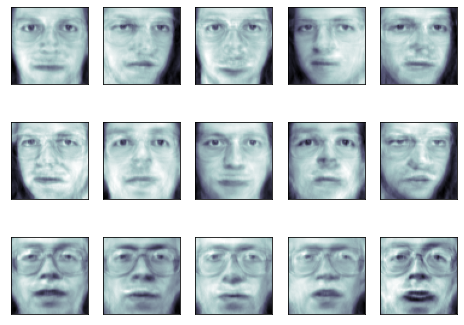

In [20]:
# Put your code here
new_Z = Z_compressed@V[:,:50].T

# (1) DO THIS: Project each centered face vector, z_i, onto V_pca 
proj = np.zeros((400,4096))

# (2) DO THIS: Add back in x_bar to your projected vectors
for i in range(400):
    proj[i,:] = new_Z[i,:] + x_bar
    
# (3) DO THIS: Reshape and visualize the first 15 uncompressed faces (use code from above to help)
proj = np.reshape(proj,(400,64,64))
fig = plt.figure(figsize=(8, 6))
for i in range(15):
    ax = fig.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(proj[i], cmap=plt.cm.bone)

**Compression were not as good as the original picture. They are blurry with spectacle not showing properly amd the faces are also without expressions.**

---
<a name="lsf_real_data"></a>
# 2. Least Squares Fitting with Real Data (22 pts)

<img src="https://cdn.pixabay.com/photo/2020/03/19/04/36/covid19-4946260_1280.jpg" width="60%" alt="Picture of the COVID19 Virus, not really needed but provides motivation.">

Image from: [https://pixabay.com/](https://pixabay.com/illustrations/covid19-corona-virus-coronavirus-4946260/) 

In your pre-class and in-class work on different days you studied infectious disease models. In this question we are going to look at some real infectious disease data. Consider the following dataset from the [COVID-19 Dashboard by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19). The model in this question will be different from the models we studied in class because this real data contains only confirmed cases, confirmed deaths, and the number of people that have recovered.

The next few cells will download the data, read it in, and plot it.

In [21]:
# Download the data (this may take a while) - do not edit this cell.
from urllib.request import urlretrieve
urls = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv',
       ]
states = ['confirmed','deaths','recovered']
colors = ['yellow', 'red', 'green']

for url,file in zip(urls,states):
    print(f"Downloading {file}")
    urlretrieve(url, f"{file}.csv");

In [22]:
# Read in the data files - do not edit this cell.
alldata = {}
allnames = {}
for file in states:
    print(f"Reading {file}")
    data=pd.read_csv(f"{file}.csv").values
    alldata[file] = data[:,4:]
    allnames[file] = data[:,1]

Reading confirmed
Reading deaths
Reading recovered


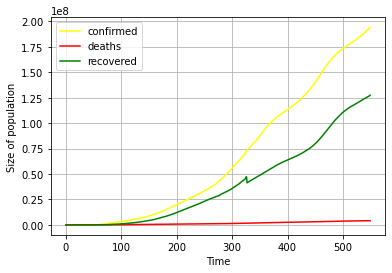

In [23]:
# Plot the data - do not edit this cell.
Infected = np.sum(alldata['confirmed'],axis=0)[:550]
Immune = np.sum(alldata['recovered'],axis=0)[:550]
Deceased = np.sum(alldata['deaths'],axis=0)[:550]
for state, color in zip(states, colors):
    plt.plot(np.sum(alldata[state],axis=0)[:550], color=color, label=state);
plt.legend()
plt.xlabel('Time')
plt.ylabel('Size of population')
plt.grid(True)

All three curves in the above plot can be modeled as a third order polynomial in the form:

\begin{equation*}
y(t) = c_0 + c_1t + c_2t^2 + c_3t^3
\end{equation*}

As an example lets start by modeling the number of infected:

In [24]:
# Store confirmed/infected population in y - do not edit this cell.
y = np.matrix(Infected).T

The `t` values are just a vector of numbers representing time which we will cast as a `numpy.array`:

In [25]:
# Store times (days) in t - do not edit this cell.
t = np.array(list(range(len(y)))).T

The unknowns are the constant values $c = [c_0, c_1, c_2, c_3]^T$.

<mark>&#9989; **<font color=red>Question 2.1:</font> (5 pts)** Define the matrix $A$ for the matrix equation $Ac=y$ that leads to the least-squares fit. Store it in the variable `A`.</mark>

In [26]:
# Put your code here
A = np.matrix([t**0, t**1, t**2,t**3]).T

<mark>&#9989; **<font color=red>Question 2.2:</font> (5 pts)** The system is clearly overdefined. Compute the pseudoinverse for $A$. Store it in the variable `Apseudo`.</mark>

In [27]:
# Put your code here
Apseudo = np.linalg.pinv(A.T*A) * A.T

<mark>&#9989; **<font color=red>Question 2.3:</font> (5 pts)** Solve the above system of equations for $c$ using the pseudoinverse. Store $c$ in the variable `c`.</mark>

In [28]:
# Put your code here
c = Apseudo * y

<mark>&#9989; **<font color=red>Question 2.4:</font> (10 pts)** Summarize all of the steps by writing a function called `solve3t()` that takes one of the three state vectors as inputs, solves using LSF and plots two curves (the original data and the model) in the same plot. The function should also return the $c$ solution vector. Here is some code to help get you started:</mark>

In [29]:
def solve3t(data):
    y = np.matrix(data).T
    t = np.array(list(range(len(y)))).T
    
    ### Your code goes here
    A = np.matrix([t**0, t**1, t**2,t**3]).T
    Apseudo = np.linalg.pinv(A.T*A) * A.T
    c = Apseudo * y
    
    plt.plot(t,y)
    plt.plot(t, A*c)
    plt.xlabel('Time')
    plt.ylabel('Number of people')
    return c

The next cell will test out your function by plotting the curves for the infected, immune, and deceased populations, along with the least squares fit polynomials.

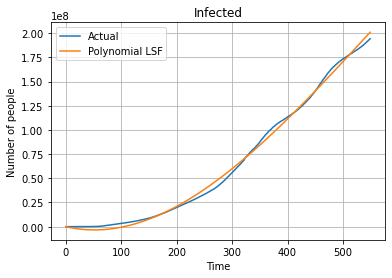

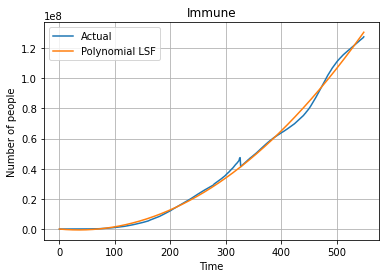

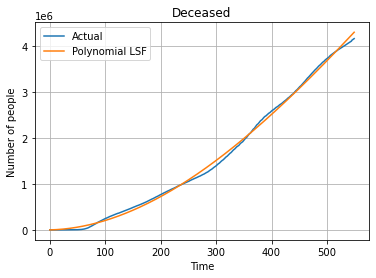

In [30]:
# This cell makes the plots, it should work if your function solve3t works.

# Infected
plt.figure()
inf = solve3t(Infected)
plt.title('Infected')
plt.legend(('Actual', 'Polynomial LSF'))
plt.grid(True)

# Immune
plt.figure()
imm = solve3t(Immune)
plt.title('Immune')
plt.legend(('Actual', 'Polynomial LSF'))
plt.grid(True)

# Deceased
plt.figure()
dec = solve3t(Deceased)
plt.title('Deceased')
plt.legend(('Actual', 'Polynomial LSF'))
plt.grid(True)

<mark>&#9989; **<font color=red>Question 2.5:</font> (5 pts)** Given the above results, which of the three curves does the poorest job modeling the population data? In your own words explain how you came to this answer.</mark>

**I believe that graph no. 2 ,i.e., the graph for Immune has the poorest model. The reason for that is that there is a local maxima at Time 315 which shows that there is a bump which shows that Polynomial LSF diverged significantly from actual data.**

---
# Congratulations, we're done!

Written by Dirk Colbry, Matthew Hirn, and Ming Yan, Michigan State University.

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.